In [5]:
import os
import pandas as pd
from IPython.display import display

# list to summon all files
sampled_dfs = []

# Find the folder
base_dir = os.getcwd()

# Supervise all files
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file == "T_ONTIME_REPORTING.csv":  # Matcher filnavne præcist
            csv_path = os.path.join(root, file)
            try:
                # Robust loading, remove useless data
                try:
                    df = pd.read_csv(csv_path, sep=None, engine="python", encoding="utf-8", on_bad_lines="skip")
                except Exception:
                    df = pd.read_csv(csv_path, sep=None, engine="python", encoding="latin1", on_bad_lines="skip")


                # sample max 300 rows, per. file
                sample_size = min(300, len(df))
                sample = df.sample(sample_size, random_state=42)
                sampled_dfs.append(sample)

                print(f" added correctly: {csv_path} ({sample_size} rows)")

            except Exception as e:
                print(f" incorrect loading {csv_path}: {e}")

# Combine files to a shared dataframe
if sampled_dfs:
    df = pd.concat(sampled_dfs, ignore_index=True)
    print(f"\n final dataset {len(df):,} rows from {len(sampled_dfs)} files.")
    display(df.head())
else:
    print("No file was found")

 added correctly: /Users/robinribelrifai/Desktop/Data months/April/T_ONTIME_REPORTING.csv (300 rows)
 added correctly: /Users/robinribelrifai/Desktop/Data months/december/T_ONTIME_REPORTING.csv (300 rows)
 added correctly: /Users/robinribelrifai/Desktop/Data months/february/T_ONTIME_REPORTING.csv (300 rows)
 added correctly: /Users/robinribelrifai/Desktop/Data months/June/T_ONTIME_REPORTING.csv (300 rows)
 added correctly: /Users/robinribelrifai/Desktop/Data months/July/T_ONTIME_REPORTING.csv (300 rows)
 added correctly: /Users/robinribelrifai/Desktop/Data months/August/T_ONTIME_REPORTING.csv (300 rows)
 added correctly: /Users/robinribelrifai/Desktop/Data months/May/T_ONTIME_REPORTING.csv (300 rows)
 added correctly: /Users/robinribelrifai/Desktop/Data months/Oktober/T_ONTIME_REPORTING.csv (300 rows)
 added correctly: /Users/robinribelrifai/Desktop/Data months/November/T_ONTIME_REPORTING.csv (300 rows)
 added correctly: /Users/robinribelrifai/Desktop/Data months/January/T_ONTIME_REPOR

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_STATE_NM,...,DEST_CITY_NAME,DEST_STATE_NM,CRS_DEP_TIME,DEP_TIME,CRS_ARR_TIME,ARR_TIME,ARR_DEL15,ARR_TIME_BLK,FLIGHTS,DISTANCE
0,2024,4,12,18,3,12/18/2024 12:00:00 AM,1293.0,12892,LAX,California,...,"Seattle, WA",Washington,600,553.0,858.0,846.0,0.0,0800-0859,1.0,954.0
1,2024,4,12,13,5,12/13/2024 12:00:00 AM,3764.0,13930,ORD,Illinois,...,"Indianapolis, IN",Indiana,1338,1336.0,1537.0,1531.0,0.0,1500-1559,1.0,177.0
2,2024,4,12,31,2,12/31/2024 12:00:00 AM,1788.0,14747,SEA,Washington,...,"Houston, TX",Texas,704,701.0,1327.0,1315.0,0.0,1300-1359,1.0,1874.0
3,2024,4,12,22,7,12/22/2024 12:00:00 AM,5487.0,11057,CLT,North Carolina,...,"Jacksonville/Camp Lejeune, NC",North Carolina,2047,2139.0,2156.0,2230.0,1.0,2100-2159,1.0,191.0
4,2024,4,12,13,5,12/13/2024 12:00:00 AM,5374.0,11150,CSG,Georgia,...,"Atlanta, GA",Georgia,1742,1734.0,1845.0,1814.0,0.0,1800-1859,1.0,83.0


In [6]:
# --- Prepare data for Linear regression Model (Leakage-Free Version) ---
# This cell creates the delay target variable and time-based predictors that can be known before departure.

import numpy as np
import pandas as pd

# --- Convert HHMM → minutes since midnight ---
# This function transforms scheduled or actual departure times into total minutes since midnight.
def hhmm_to_minutes(x):
    try:
        x = int(float(str(x).strip()))
        h, m = x // 100, x % 100
        return min(h * 60 + m, 1439)  # cap at 23:59
    except:
        return np.nan

# --- Create minute-based columns for actual and scheduled departure times ---
if "DEP_TIME" in df.columns:
    df["DEP_TIME_MIN"] = df["DEP_TIME"].apply(hhmm_to_minutes)

if "CRS_DEP_TIME" in df.columns:
    df["CRS_DEP_TIME_MIN"] = df["CRS_DEP_TIME"].apply(hhmm_to_minutes)

# --- Calculate delay in minutes (only for creating the target variable) ---
# Note: This column will NOT be used as an input feature to prevent data leakage.
if {"DEP_TIME_MIN", "CRS_DEP_TIME_MIN"}.issubset(df.columns):
    df["DEP_DELAY_MIN"] = df["DEP_TIME_MIN"] - df["CRS_DEP_TIME_MIN"]

print("\n'DEP_DELAY_MIN' successfully calculated.")
display(df[["DEP_TIME_MIN", "CRS_DEP_TIME_MIN", "DEP_DELAY_MIN"]].head())

# --- Create the binary target variable for linear regression ---
# 1 = delayed more than 15 minutes, 0 = on time
df["DELAYED"] = (df["DEP_DELAY_MIN"] > 15).astype(int)

print("\nTarget variable 'DELAYED' created (1 = delayed, 0 = on time).")
display(df[["DEP_DELAY_MIN", "DELAYED"]].head())

# --- Create cyclic time features for departure time ---
# These encode the time of day in a circular format to capture daily patterns
# (e.g., 23:59 and 00:01 are close in time, not far apart).
if "CRS_DEP_TIME_MIN" in df.columns:
    df["DEP_TIME_sin"] = np.sin(2 * np.pi * df["CRS_DEP_TIME_MIN"] / 1440)
    df["DEP_TIME_cos"] = np.cos(2 * np.pi * df["CRS_DEP_TIME_MIN"] / 1440)
    print("\nCyclic time features 'DEP_TIME_sin' and 'DEP_TIME_cos' created successfully.")
    display(df[["CRS_DEP_TIME_MIN", "DEP_TIME_sin", "DEP_TIME_cos"]].head())



'DEP_DELAY_MIN' successfully calculated.


,DEP_TIME_MIN,CRS_DEP_TIME_MIN,DEP_DELAY_MIN
0,353.0,360,-7.0
1,816.0,818,-2.0
2,421.0,424,-3.0
3,1299.0,1247,52.0
4,1054.0,1062,-8.0



Target variable 'DELAYED' created (1 = delayed, 0 = on time).


,DEP_DELAY_MIN,DELAYED
0,-7.0,0
1,-2.0,0
2,-3.0,0
3,52.0,1
4,-8.0,0



Cyclic time features 'DEP_TIME_sin' and 'DEP_TIME_cos' created successfully.


,CRS_DEP_TIME_MIN,DEP_TIME_sin,DEP_TIME_cos
0,360,1.000000,6.123234e-17
1,818,-0.414693,-9.099613e-01
2,424,0.961262,-2.756374e-01
3,1247,-0.746057,6.658817e-01
4,1062,-0.996917,-7.845910e-02


In [7]:
# --- Convert DEP_TIME_MIN into 15-minute bins (categorical) ---
df["DEP_TIME_BIN"] = pd.cut(
    df["DEP_TIME_MIN"],
    bins=range(0, 1441, 15),
    labels=[f"{h:02d}:{m:02d}" for h in range(24) for m in range(0, 60, 15)]
)

print("\n Sample of 15-minute bins:")
display(df[["DEP_TIME_MIN", "DEP_TIME_BIN"]].head())

# --- Select model features ---
selected_features = ["MONTH",         
    "DAY_OF_WEEK",  
    "DAY_OF_MONTH",
    "DISTANCE",       
    "ORIGIN",        
    "DEST", 
    "DEP_TIME_sin",   
    "DEP_TIME_cos",   
    "OP_CARRIER_FL_NUM"]

# --- Keep only relevant rows (drop NaN) ---
df_model = df[selected_features + ["DELAYED"]].dropna()

X = df_model[selected_features]
y = df_model["DELAYED"]

print(f"\n Final dataset ready for modeling: {len(X)} rows, {len(selected_features)} features.")
display(X.head())


 Sample of 15-minute bins:


,DEP_TIME_MIN,DEP_TIME_BIN
0,353.0,05:45
1,816.0,13:30
2,421.0,07:00
3,1299.0,21:30
4,1054.0,17:30



 Final dataset ready for modeling: 3600 rows, 9 features.


,MONTH,DAY_OF_WEEK,DAY_OF_MONTH,DISTANCE,ORIGIN,DEST,DEP_TIME_sin,DEP_TIME_cos,OP_CARRIER_FL_NUM
0,12,3,18,954.0,LAX,SEA,1.000000,6.123234e-17,1293.0
1,12,5,13,177.0,ORD,IND,-0.414693,-9.099613e-01,3764.0
2,12,2,31,1874.0,SEA,IAH,0.961262,-2.756374e-01,1788.0
3,12,7,22,191.0,CLT,OAJ,-0.746057,6.658817e-01,5487.0
4,12,5,13,83.0,CSG,ATL,-0.996917,-7.845910e-02,5374.0


Dataset for linear regression: 3546 rows

--- Linear Regression Performance (Delay in Minutes) ---
Baseline → RMSE: 44.06 | MAE: 20.62 | R²: -0.001
Linear   → RMSE: 47.97 | MAE: 21.63 | R²: -0.186
Ridge    → RMSE: 44.10 | MAE: 19.95 | R²: -0.003
Lasso    → RMSE: 44.03 | MAE: 20.21 | R²: 0.000


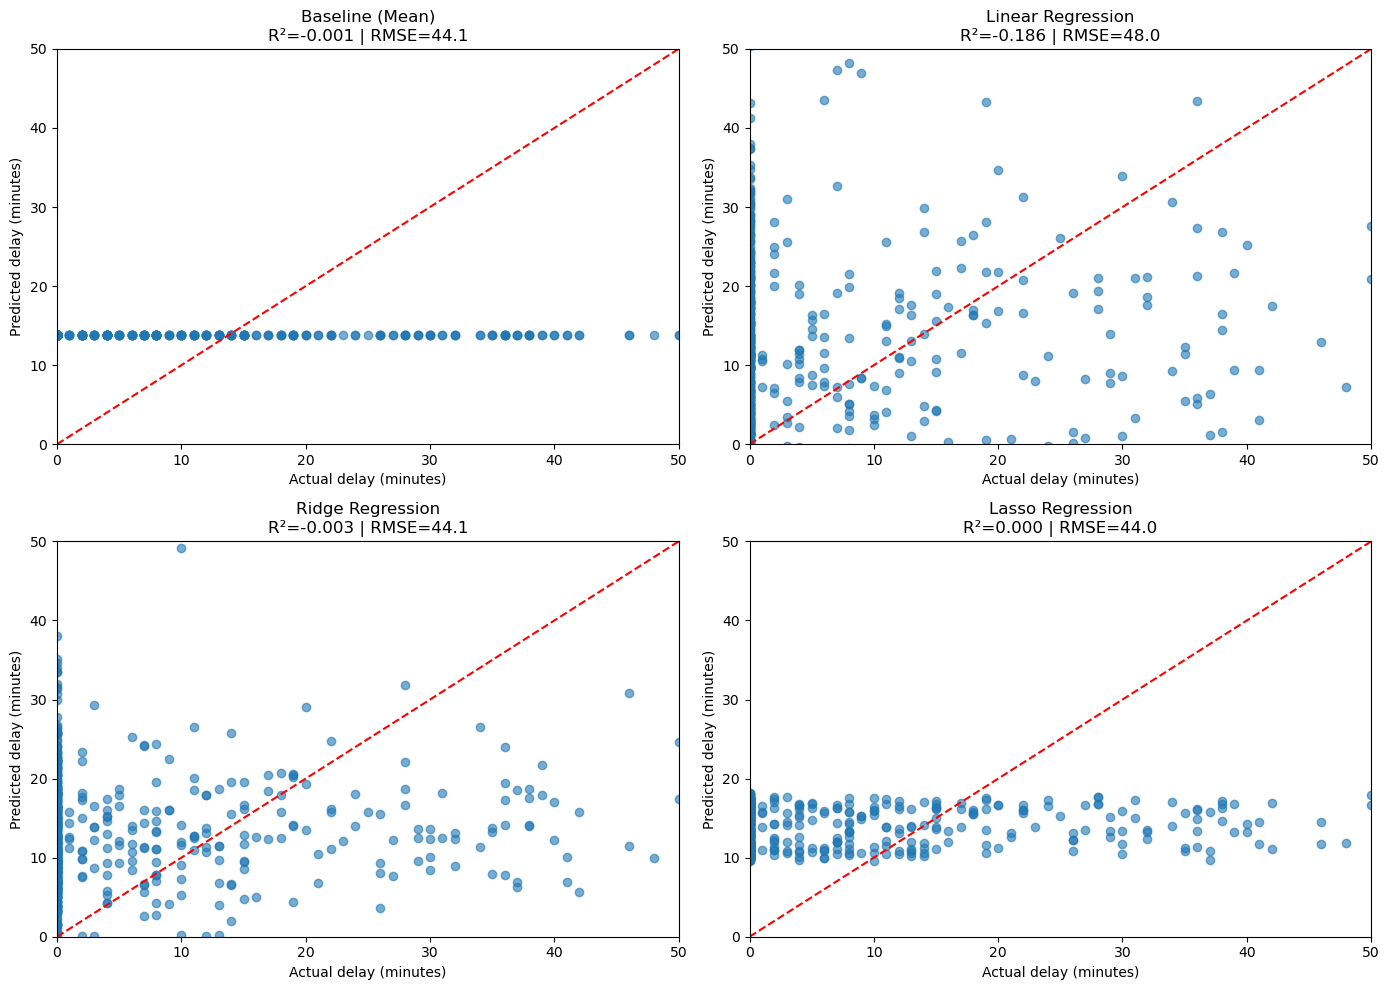

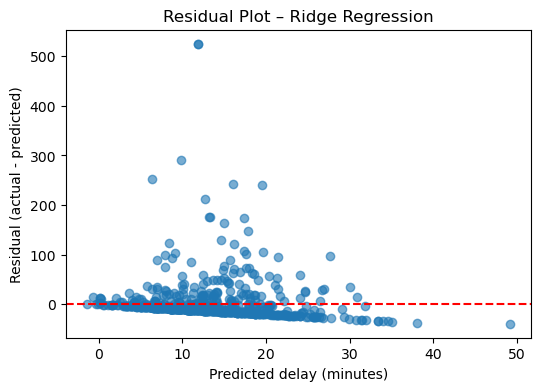

,Model,RMSE (min),MAE (min),R²,Alpha
0,Baseline (Mean),44.055673,20.618897,-0.000571,NaN
1,Linear Regression,47.967148,21.633446,-0.186130,NaN
2,Ridge,44.098392,19.946851,-0.002513,30.0
3,Lasso,44.034754,20.210311,0.000379,1.0


In [16]:
#
# LINEAR REGRESSION
# Goal: predict delay in minutes
# 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from IPython.display import display


# 
# 1. CREATE TARGET VARIABLE (DELAY IN MINUTES)
# 
# DELAYED is a continuous variable (minutes of delay)

df["DELAYED"] = np.clip(
    df["DEP_TIME_MIN"] - df["CRS_DEP_TIME_MIN"],
    a_min=0,
    a_max=None
)

# Keep only rows with a valid target
df_model = df.dropna(subset=["DELAYED"]).copy()


# 
# 2. SELECT FEATURES
# 

numeric_features = [
    "MONTH",
    "DAY_OF_WEEK",
    "DISTANCE",
    "DEP_TIME_sin",
    "DEP_TIME_cos",
    "OP_CARRIER_FL_NUM"
]

categorical_features = [
    "ORIGIN",
    "DEST"
]

numeric_features = [c for c in numeric_features if c in df_model.columns]
categorical_features = [c for c in categorical_features if c in df_model.columns]

X = df_model[numeric_features + categorical_features]
y = df_model["DELAYED"].astype(float)

print(f"Dataset for linear regression: {len(X)} rows")


# 
# 3. TRAIN / TEST SPLIT
# 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# 
# 4. PREPROCESSING
# 

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)


# 
# 5. DEFINE MODELS
# 

pipe_dummy = Pipeline([
    ("preprocessor", preprocessor),
    ("model", DummyRegressor(strategy="mean"))
])

pipe_lr = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

pipe_ridge = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RidgeCV(
        alphas=[0.1, 1, 3, 10, 30],
        cv=5,
        scoring="neg_mean_squared_error"
    ))
])

pipe_lasso = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LassoCV(
        alphas=[0.1, 1, 3, 10, 30],
        cv=5,
        random_state=42,
        max_iter=10000
    ))
])


# 
# 6. TRAIN MODELS
# 

pipe_dummy.fit(X_train, y_train)
pipe_lr.fit(X_train, y_train)
pipe_ridge.fit(X_train, y_train)
pipe_lasso.fit(X_train, y_train)

y_pred_dummy = pipe_dummy.predict(X_test)
y_pred_lr = pipe_lr.predict(X_test)
y_pred_ridge = pipe_ridge.predict(X_test)
y_pred_lasso = pipe_lasso.predict(X_test)


# 
# 7. MODEL EVALUATION
# 

rmse_dummy = np.sqrt(mean_squared_error(y_test, y_pred_dummy))
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

mae_dummy = mean_absolute_error(y_test, y_pred_dummy)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)

r2_dummy = r2_score(y_test, y_pred_dummy)
r2_lr = r2_score(y_test, y_pred_lr)
r2_ridge = r2_score(y_test, y_pred_ridge)
r2_lasso = r2_score(y_test, y_pred_lasso)

print("\n--- Linear Regression Performance (Delay in Minutes) ---")
print(f"Baseline → RMSE: {rmse_dummy:.2f} | MAE: {mae_dummy:.2f} | R²: {r2_dummy:.3f}")
print(f"Linear   → RMSE: {rmse_lr:.2f} | MAE: {mae_lr:.2f} | R²: {r2_lr:.3f}")
print(f"Ridge    → RMSE: {rmse_ridge:.2f} | MAE: {mae_ridge:.2f} | R²: {r2_ridge:.3f}")
print(f"Lasso    → RMSE: {rmse_lasso:.2f} | MAE: {mae_lasso:.2f} | R²: {r2_lasso:.3f}")


# 
# 8. VISUAL COMPARISON OF ALL MODELS
# 

max_minutes = 50
plt.figure(figsize=(14,10))

models = [
    ("Baseline (Mean)", y_pred_dummy, r2_dummy, rmse_dummy),
    ("Linear Regression", y_pred_lr, r2_lr, rmse_lr),
    ("Ridge Regression", y_pred_ridge, r2_ridge, rmse_ridge),
    ("Lasso Regression", y_pred_lasso, r2_lasso, rmse_lasso)
]

for i, (name, preds, r2, rmse) in enumerate(models, 1):
    plt.subplot(2, 2, i)
    plt.scatter(y_test, preds, alpha=0.6)
    plt.plot([0, max_minutes], [0, max_minutes], "r--")
    plt.xlim(0, max_minutes)
    plt.ylim(0, max_minutes)
    plt.title(f"{name}\nR²={r2:.3f} | RMSE={rmse:.1f}")
    plt.xlabel("Actual delay (minutes)")
    plt.ylabel("Predicted delay (minutes)")

plt.tight_layout()
plt.show()


# 
# 9. RESIDUAL PLOT (RIDGE)
# 

residuals = y_test - y_pred_ridge

plt.figure(figsize=(6,4))
plt.scatter(y_pred_ridge, residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted delay (minutes)")
plt.ylabel("Residual (actual - predicted)")
plt.title("Residual Plot – Ridge Regression")
plt.show()


# 
# 10. SUMMARY TABLE
# 

summary = pd.DataFrame({
    "Model": ["Baseline (Mean)", "Linear Regression", "Ridge", "Lasso"],
    "RMSE (min)": [rmse_dummy, rmse_lr, rmse_ridge, rmse_lasso],
    "MAE (min)": [mae_dummy, mae_lr, mae_ridge, mae_lasso],
    "R²": [r2_dummy, r2_lr, r2_ridge, r2_lasso],
    "Alpha": [
        None,
        None,
        pipe_ridge.named_steps["model"].alpha_,
        pipe_lasso.named_steps["model"].alpha_
    ]
})

display(summary)
